In [37]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sys
import time
import logging
import watchdog.observers 
import watchdog.events 
import os
import threading
import pickle

In [38]:
dataframes_file = 'dataframes.pkl'
try:
    # Load dataframes from file if it exists
    if os.path.exists(dataframes_file) and os.path.getsize(dataframes_file) > 0:
        with open(dataframes_file, 'rb') as f:
            dataframes = pickle.load(f)
    else:
        dataframes = []
except EOFError:
    dataframes = []
processed_files = set()

In [39]:
for i, df in enumerate(dataframes):
    print(f'{i} : {df[1]}')

In [40]:
class Handler(watchdog.events.PatternMatchingEventHandler):
    def __init__(self):

        # Set the patterns for PatternMatchingEventHandler
        watchdog.events.PatternMatchingEventHandler.__init__(self, patterns=['*.csv'],
                                                             ignore_directories=True, case_sensitive=False)
 
    def on_created(self, event):
        print("Watchdog received created event - % s." % event.src_path)
        #filename = os.path.basename(event.src_path).split('/')[-1]
        return event.src_path
        # Event is created, you can process it now
            # Check if file already processed



    def on_modified(self, event):
        #filename = self.on_created(event)
        file_path = event.src_path
        print(f"Watchdog received modified event - {file_path}.")
        filename = os.path.basename(file_path).split('/')[-1]
        if filename not in processed_files:
            processed_files.add(filename)
            historical_size = -1
            max_wait_time = 60  # Maximum time to wait for the file to stabilize (in seconds)
            start_time = time.time()

            while True:
                try:
                    current_size = os.path.getsize(file_path)
                    if current_size == historical_size:
                        break
                    historical_size = current_size
                except FileNotFoundError:
                    pass
                if time.time() - start_time > max_wait_time:
                    print(f"Timeout waiting for file {file_path} to stabilize.")
                    break
                time.sleep(1)
            print("File copy has now finished or timed out.")
            print("File copy has now finished")

            global Created
            Created = True
            if os.path.exists(file_path):
                file_data = pd.read_csv(file_path)
                file_df = pd.DataFrame(file_data)
                dataframes.append([file_df, filename[:-4]])
                # Save dataframes to file
                with open(dataframes_file, 'wb') as f:
                    pickle.dump(dataframes, f)
            return Created  # Only return Created if the file is not processed
        else:
            print(f"Skipping duplicate file: {filename}")
            return None


if __name__=='__main__':
    src_path = os.getcwd()
    #r"/home/jasmine/encryption/cryptlibs"
    Created = False
    event_handler = Handler()

    observer = watchdog.observers.Observer()
    observer.schedule(event_handler, path=src_path, recursive=True)
    observer.start()
    try:
        while not Created:
            pass
    except KeyboardInterrupt:
        observer.stop()
    finally:
        observer.stop()
        observer.join()


Watchdog received created event - /home/jasmine/encryption/libg-lite/LibgcryptRSA-2048-OAEP.csv.
Watchdog received modified event - /home/jasmine/encryption/libg-lite/LibgcryptRSA-2048-OAEP.csv.
File copy has now finished or timed out.
File copy has now finished


In [41]:
for i, df in enumerate(dataframes):
    print(f'{i} : {df[1]}')

0 : LibgcryptRSA-2048-OAEP


In [42]:
processed_files.clear()

In [50]:
length = {" Data length":[]}
length[" Data length"].append(14)
for i in range(50, 1024, 10):
    length[" Data length"].append(i)

data_length = pd.DataFrame(length)


In [51]:
N = len(dataframes)
for i, dataframe in enumerate(dataframes):
    dataframes[i][0] = dataframes[i][0].rename({' Run Time': 'Run Time' + str(i), ' CPU cycles': 'CPU cycles'+str(i),  ' Throughput': 'Throughput'+str(i)}, axis=1)
    

In [52]:
runtimes = data_length
cpu_cycles = data_length
throughputs = data_length

for i, df_set in enumerate(dataframes):
    df = df_set[0]
    runtimes = pd.concat([runtimes, df.iloc[:, 2]], axis=1).reindex(runtimes.index)
    cpu_cycles = pd.concat([cpu_cycles, df.iloc[:, 1]], axis=1).reindex(cpu_cycles.index)
    throughputs = pd.concat([throughputs, df.iloc[:, 3]], axis=1).reindex(throughputs.index)
    

In [53]:
categorised_dfs = [runtimes, cpu_cycles, throughputs]
for i, df in enumerate(categorised_dfs):
    categorised_dfs[i] = categorised_dfs[i].iloc[1:]
runtimes, cpu_cycles, throughputs = categorised_dfs

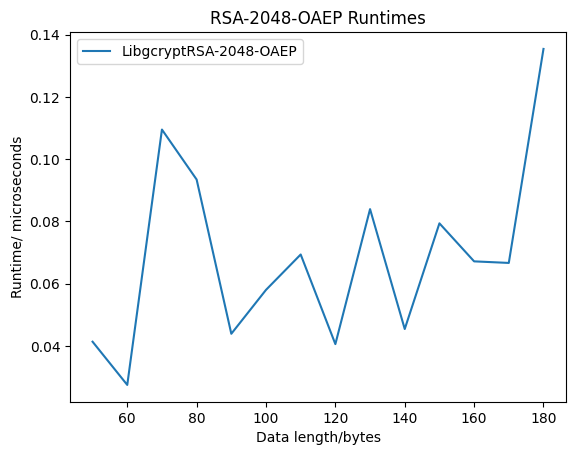

In [57]:
for i, dataframe in enumerate(dataframes):
    plt.plot(runtimes.iloc[:,0],runtimes.iloc[:,i+1], label = str(dataframes[i][1]))


plt.xlabel("Data length/bytes")
plt.ylabel("Runtime/ microseconds")
plt.title('RSA-2048-OAEP Runtimes')

plt.legend()

plt.show()

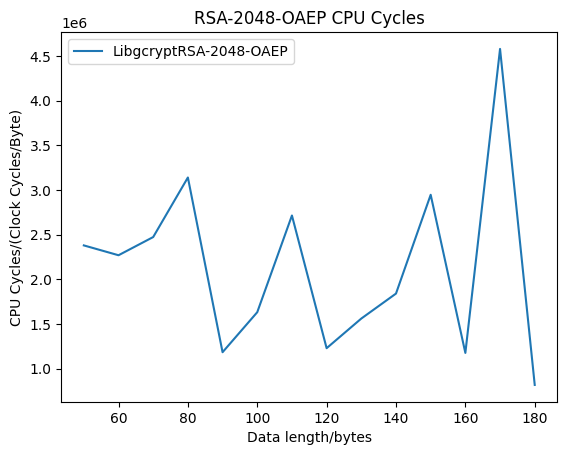

In [62]:
for i, dataframe in enumerate(dataframes):
    plt.plot(cpu_cycles.iloc[:,0],cpu_cycles.iloc[:,i+1], label = str(dataframes[i][1]))

plt.xlabel("Data length/bytes")
plt.ylabel("CPU Cycles/(Clock Cycles/Byte)")
plt.title('RSA-2048-OAEP CPU Cycles')

plt.legend()

plt.show()

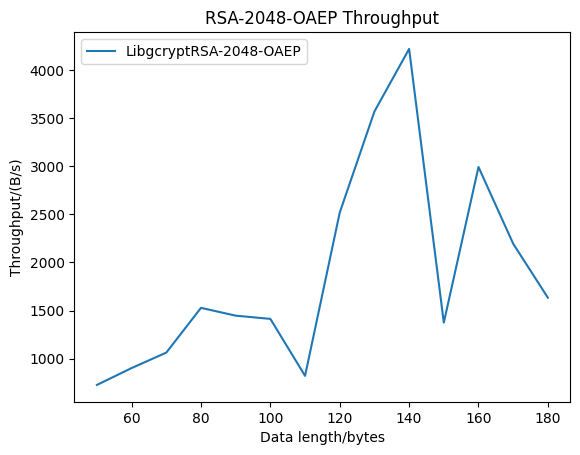

In [63]:
for i, dataframe in enumerate(dataframes):
    plt.plot(throughputs.iloc[:,0],throughputs.iloc[:,i+1], label = str(dataframes[i][1]))

plt.xlabel("Data length/bytes")
plt.ylabel("Throughput/(B/s)")
plt.title('RSA-2048-OAEP Throughput')

plt.legend()

plt.show()